Importar Librerias

In [1]:
"""
ÁRBOLES DE DECISIÓN PARA CLASIFICACIÓN DE ENFERMEDADES DE CEBOLLA
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

#Librerias para guardar archivos
import joblib
from pathlib import Path
out_dir = Path.cwd() / "Arbol_Desicion" #Carpeta para guardar y cargar los modelos de K-means
out_dir.mkdir(parents=True, exist_ok=True)

Función para cargar y preparar los datos desde el CSV

In [2]:
# ============================================================
# CARGA Y PREPARACIÓN DE DATOS
# ============================================================

def cargar_datos_desde_csv(csv_path='onion_dataset.csv', tamano_imagen=(32, 32)):
    """
    Carga las imágenes desde el CSV y las convierte a vectores de características.
    El CSV debe tener al menos las columnas: 'image_path' y 'class'.
    """
    print("=" * 60)
    print("CARGANDO DATASET")
    print("=" * 60)

    df = pd.read_csv(csv_path)
    print(f"Archivo CSV cargado: {len(df)} imágenes encontradas")

    clases_unicas = df['class'].unique()
    print(f"Clases encontradas: {len(clases_unicas)}")
    for i, clase in enumerate(clases_unicas, 1):
        print(f"   {i}. {clase}")

    X = []
    y = []
    errores = 0

    for idx, fila in df.iterrows():
        try:
            imagen = Image.open(fila['image_path'])

            if imagen.mode != 'RGB':
                imagen = imagen.convert('RGB')

            imagen = imagen.resize(tamano_imagen)
            imagen_array = np.array(imagen).flatten()
            imagen_normalizada = imagen_array / 255.0

            X.append(imagen_normalizada)
            y.append(fila['class'])

            if (idx + 1) % 100 == 0:
                print(f"   Procesadas {idx + 1} imágenes...")

        except Exception as e:
            errores += 1
            print(f"   [ERROR] No se pudo procesar la imagen en fila {idx}: {e}")

    X = np.array(X)
    y = np.array(y)

    print(f"\nTotal de imágenes procesadas correctamente: {len(X)}")
    print(f"Total de errores al cargar imágenes: {errores}")

    return X, y, clases_unicas


Función para optimizar los hiperparametros

In [3]:
def optimizar_hiperparametros(X_train, y_train, busqueda_rapida=True):
    """
    Optimiza los hiperparámetros del Árbol de Decisión usando GridSearchCV.
    """
    print("\n" + "=" * 60)
    print("OPTIMIZACIÓN DE HIPERPARÁMETROS - ÁRBOL DE DECISIÓN")
    print("=" * 60)

    modelo_base = DecisionTreeClassifier(random_state=42)

    if busqueda_rapida:
        param_grid = {
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': [None, 'sqrt', 'log2']
        }
    else:
        # Búsqueda más amplia (puede tardar más)
        param_grid = {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': [None, 10, 20, 30, 40, 50],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 4, 8],
            'max_features': [None, 'sqrt', 'log2'],
            'class_weight': [None, 'balanced']
        }

    grid_search = GridSearchCV(
        estimator=modelo_base,
        param_grid=param_grid,
        scoring='accuracy',
        cv=3,
        n_jobs=-1,
        verbose=2
    )

    grid_search.fit(X_train, y_train)

    print("\nMejores hiperparámetros encontrados:")
    for k, v in grid_search.best_params_.items():
        print(f"   {k}: {v}")

    print(f"\nMejor score de validación: {grid_search.best_score_:.4f}")

    return grid_search.best_params_

Función para entrenar el modelo

In [4]:
def entrenar_arbol_decision(X_train, y_train, **params):
    """
    Entrena un modelo de Árbol de Decisión.
    """
    print("\n" + "=" * 60)
    print("ENTRENANDO ÁRBOL DE DECISIÓN")
    print("=" * 60)

    default_params = {
        'criterion': 'gini',
        'max_depth': None,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'max_features': None,
        'random_state': 42
    }

    default_params.update(params)

    print("\nParámetros finales del modelo:")
    for k, v in default_params.items():
        print(f"   {k}: {v}")

    modelo = DecisionTreeClassifier(**default_params)
    modelo.fit(X_train, y_train)

    print("\nModelo entrenado correctamente.")
    print(f"Profundidad del árbol: {modelo.get_depth()}")
    print(f"Número de hojas: {modelo.get_n_leaves()}")

    return modelo

Función para evaluar el Modelo

In [5]:
def evaluar_modelo(modelo, X_test, y_test, nombres_clases):
    """
    Evalúa el modelo y muestra métricas.
    """
    print("\n" + "=" * 60)
    print("EVALUACIÓN DEL MODELO - ÁRBOL DE DECISIÓN")
    print("=" * 60)

    # Predicciones
    y_pred = modelo.predict(X_test)

    # Accuracy global
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nACCURACY GENERAL: {accuracy:.4f} ({accuracy * 100:.2f}%)")

    # Reporte detallado
    print("\nREPORTE DETALLADO POR CLASE:")
    print("-" * 60)
    reporte = classification_report(
        y_test,
        y_pred,
        target_names=nombres_clases,
        zero_division=0
    )
    print(reporte)

    # Matriz de confusión
    matriz_confusion = confusion_matrix(y_test, y_pred)

    return accuracy, y_pred, matriz_confusion

Función para visualizar la matriz de confusión

In [6]:
def visualizar_matriz_confusion(matriz_confusion, nombres_clases):
    """
    Visualiza la matriz de confusión.
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        matriz_confusion,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=nombres_clases,
        yticklabels=nombres_clases,
        cbar=True
    )
    plt.title('Matriz de Confusión - Árbol de Decisión', fontsize=14)
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(out_dir/'matriz_confusion_dt.png', dpi=100, bbox_inches='tight')
    plt.show()

Funcion para mostrar las caracteísticas del árbol

In [7]:
def analizar_importancia_caracteristicas(modelo, n_top=20):
    """
    Analiza y visualiza la importancia de las características.
    """
    print("\n" + "=" * 60)
    print("IMPORTANCIA DE CARACTERÍSTICAS")
    print("=" * 60)

    importancias = modelo.feature_importances_
    indices = np.argsort(importancias)[::-1]

    print(f"\nTop {n_top} características más importantes:")
    for i in range(min(n_top, len(importancias))):
        print(f"   {i + 1}. Índice {indices[i]} - importancia {importancias[indices[i]]:.6f}")

    # Histograma de importancias
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importancias)), importancias)
    plt.xlabel('Índice de característica')
    plt.ylabel('Importancia')
    plt.ylim((0,0.01))
    plt.title('Distribución de Importancia de Características (Árbol de Decisión)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir/'importancia_caracteristicas_dt.png', dpi=100, bbox_inches='tight')
    plt.show()

    # Importancia acumulada
    importancias_ordenadas = importancias[indices]
    importancia_acumulada = np.cumsum(importancias_ordenadas)
    n_90 = np.where(importancia_acumulada >= 0.9)[0][0] + 1 if np.any(importancia_acumulada >= 0.9) else len(importancias)

    print(f"\nCaracterísticas necesarias para 90% de importancia: {n_90}")
    print(f"Porcentaje del total: {n_90 / len(importancias) * 100:.1f}%")

Función para analizar la complejidad del arbol

In [8]:
def analizar_complejidad_arbol(modelo):
    """
    Muestra información sobre la complejidad del árbol de decisión.
    """
    print("\n" + "=" * 60)
    print("ANÁLISIS DE COMPLEJIDAD DEL ÁRBOL")
    print("=" * 60)

    tree = modelo.tree_
    n_nodos = tree.node_count
    profundidad = modelo.get_depth()
    n_hojas = modelo.get_n_leaves()

    print(f"Número total de nodos: {n_nodos}")
    print(f"Profundidad del árbol: {profundidad}")
    print(f"Número de hojas: {n_hojas}")

    # Distribución de muestras en las hojas
    children_left = tree.children_left
    children_right = tree.children_right
    is_leaf = (children_left == -1) & (children_right == -1)
    muestras_hojas = tree.n_node_samples[is_leaf]

    print(f"Muestras mínimas en una hoja: {muestras_hojas.min()}")
    print(f"Muestras máximas en una hoja: {muestras_hojas.max()}")
    print(f"Muestras promedio por hoja: {muestras_hojas.mean():.2f}")

    plt.figure(figsize=(10, 6))
    plt.hist(muestras_hojas, bins=20, edgecolor='black', alpha=0.7)
    plt.xlabel('Número de muestras por hoja')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de muestras en las hojas del árbol')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_dir/'distribucion_muestras_hojas_dt.png', dpi=100, bbox_inches='tight')
    plt.show()

Función para visualizar el árbol

In [9]:
def visualizar_arbol(modelo, nombres_clases, max_depth_visual=3):
    """
    Dibuja el árbol de decisión (recortado a cierta profundidad para que sea legible).
    """
    print("\n" + "=" * 60)
    print("VISUALIZACIÓN DEL ÁRBOL DE DECISIÓN (PROFUNDIDAD LIMITADA)")
    print("=" * 60)

    plt.figure(figsize=(20, 10))
    plot_tree(
        modelo,
        max_depth=max_depth_visual,
        class_names=nombres_clases,
        filled=True,
        rounded=True,
        fontsize=8
    )
    plt.tight_layout()
    plt.savefig(out_dir/'arbol_decision_visual.png', dpi=100, bbox_inches='tight')
    plt.show()

Función Para predecir una nueva imagen

In [25]:
def predecir_imagen(ruta_imagen, modelo_path=out_dir/'modelo_arbol_decision.pkl'):
    """
    Predice la clase de una nueva imagen usando el Árbol de Decisión entrenado.

    Parámetros
    ----------
    ruta_imagen : str
        Ruta a la imagen que se quiere clasificar.
    modelo_path : str
        Ruta al modelo guardado.

    Returns
    -------
    str : Clase predicha
    """
    try:
        import matplotlib.pyplot as plt  # importar aquí por si no está en el global

        print("\n" + "=" * 60)
        print("PREDICCIÓN PARA UNA NUEVA IMAGEN")
        print("=" * 60)

        # Cargar modelo y LabelEncoder
        modelo = joblib.load(modelo_path)
        label_encoder = joblib.load(out_dir/'label_encoder_dt.pkl')

        # Cargar imagen original (para mostrarla)
        imagen_original = Image.open(ruta_imagen)

        # Procesar imagen para el modelo
        imagen = imagen_original
        if imagen.mode != 'RGB':
            imagen = imagen.convert('RGB')
        imagen = imagen.resize((32, 32))
        imagen_array = np.array(imagen).flatten() / 255.0
        imagen_array = imagen_array.reshape(1, -1)

        # Predicción
        prediccion = modelo.predict(imagen_array)[0]
        probabilidades = modelo.predict_proba(imagen_array)[0]

        clase_predicha = label_encoder.inverse_transform([prediccion])[0]
        print(f"\nClase predicha: {clase_predicha}")

        # Top 3 clases más probables
        indices_top = np.argsort(probabilidades)[::-1][:3]
        print("\nTop 3 predicciones:")
        for i, idx in enumerate(indices_top):
            clase = label_encoder.inverse_transform([idx])[0]
            prob = probabilidades[idx]
            print(f"   {i + 1}. {clase}: {prob:.2%}")

        # Mostrar la imagen con la clase predicha
        plt.figure(figsize=(4, 4))
        plt.imshow(imagen_original)
        plt.axis('off')
        plt.title(f"Predicción: {clase_predicha}")
        plt.tight_layout()
        plt.show()

        return clase_predicha

    except Exception as e:
        print(f"ERROR: {e}")
        return None


Características del Modelo

In [11]:
CSV_PATH = 'onion_dataset.csv'
TAMANO_IMAGEN = (32, 32)
TEST_SIZE = 0.2
OPTIMIZAR_PARAMS = True  # Cambiar a False para usar parámetros por defecto

In [12]:
# 1. Cargar datos
X, y, clases_unicas = cargar_datos_desde_csv(CSV_PATH, TAMANO_IMAGEN)

CARGANDO DATASET
Archivo CSV cargado: 13229 imágenes encontradas
Clases encontradas: 15
   1. Alternaria_D
   2. Botrytis Leaf Blight
   3. Bulb Rot
   4. Bulb_blight-D
   5. Caterpillar-P
   6. Downy mildew
   7. Fusarium-D
   8. Healthy leaves
   9. Iris yellow virus_augment
   10. Purple blotch
   11. Rust
   12. Virosis-D
   13. Xanthomonas Leaf Blight
   14. onion1
   15. stemphylium Leaf Blight
   Procesadas 100 imágenes...
   Procesadas 200 imágenes...
   Procesadas 300 imágenes...
   Procesadas 400 imágenes...
   Procesadas 500 imágenes...
   Procesadas 600 imágenes...
   Procesadas 700 imágenes...
   Procesadas 800 imágenes...
   Procesadas 900 imágenes...
   Procesadas 1000 imágenes...
   Procesadas 1100 imágenes...
   Procesadas 1200 imágenes...
   Procesadas 1300 imágenes...
   Procesadas 1400 imágenes...
   Procesadas 1500 imágenes...
   Procesadas 1600 imágenes...
   Procesadas 1700 imágenes...
   Procesadas 1800 imágenes...
   Procesadas 1900 imágenes...
   Procesadas 20

In [13]:
# 2. Codificar etiquetas
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [14]:
# 3. Separar en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=TEST_SIZE,
    random_state=42,
    stratify=y_encoded
)

print(f"\nTamaño de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño de prueba: {X_test.shape[0]} muestras")


Tamaño de entrenamiento: 10583 muestras
Tamaño de prueba: 2646 muestras


In [15]:
# 4. Optimización de hiperparámetros
mejores_params = optimizar_hiperparametros(X_train, y_train, busqueda_rapida=True)


OPTIMIZACIÓN DE HIPERPARÁMETROS - ÁRBOL DE DECISIÓN
Fitting 3 folds for each of 216 candidates, totalling 648 fits

Mejores hiperparámetros encontrados:
   criterion: entropy
   max_depth: None
   max_features: None
   min_samples_leaf: 1
   min_samples_split: 2

Mejor score de validación: 0.4836


In [16]:
# 5. Entrenar modelo
modelo = entrenar_arbol_decision(X_train, y_train, **mejores_params)


ENTRENANDO ÁRBOL DE DECISIÓN

Parámetros finales del modelo:
   criterion: entropy
   max_depth: None
   min_samples_split: 2
   min_samples_leaf: 1
   max_features: None
   random_state: 42

Modelo entrenado correctamente.
Profundidad del árbol: 25
Número de hojas: 1736


In [17]:
# 6. Evaluar Modelo
accuracy, y_pred, matriz = evaluar_modelo(
    modelo,
    X_test,
    y_test,
    nombres_clases=label_encoder.classes_
)


EVALUACIÓN DEL MODELO - ÁRBOL DE DECISIÓN

ACCURACY GENERAL: 0.5620 (56.20%)

REPORTE DETALLADO POR CLASE:
------------------------------------------------------------
                           precision    recall  f1-score   support

             Alternaria_D       0.61      0.58      0.60       166
     Botrytis Leaf Blight       0.31      0.21      0.25        58
                 Bulb Rot       0.00      0.00      0.00         1
            Bulb_blight-D       0.97      0.97      0.97        79
            Caterpillar-P       0.79      0.87      0.83       312
             Downy mildew       0.00      0.00      0.00         7
               Fusarium-D       0.64      0.70      0.67       255
           Healthy leaves       0.58      0.57      0.57       688
Iris yellow virus_augment       0.35      0.32      0.34       380
            Purple blotch       0.45      0.45      0.45       170
                     Rust       0.42      0.51      0.46        43
                Virosis-D 

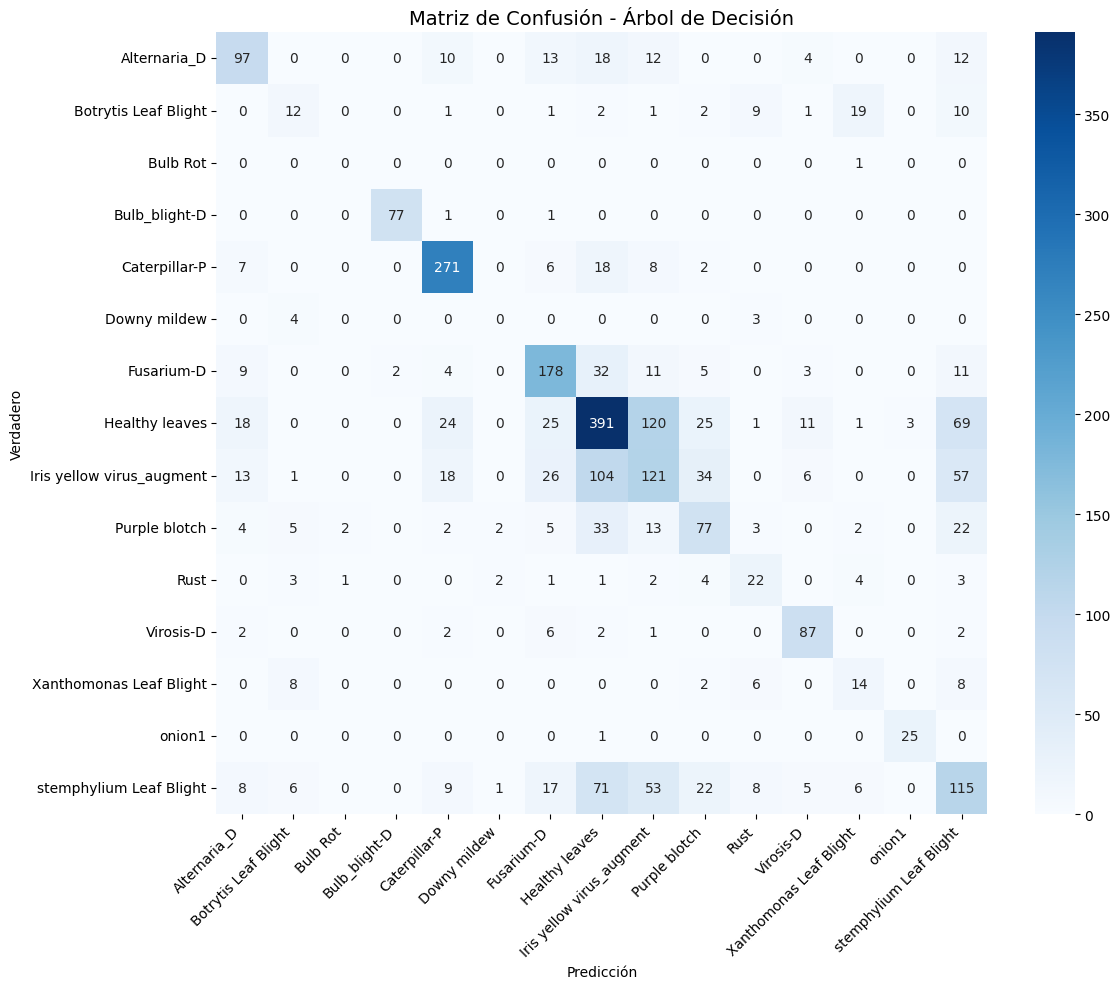

In [18]:
# 7. Visualizar Matriz de Confusión
visualizar_matriz_confusion(matriz, label_encoder.classes_)



IMPORTANCIA DE CARACTERÍSTICAS

Top 20 características más importantes:
   1. Índice 3 - importancia 0.080160
   2. Índice 332 - importancia 0.037276
   3. Índice 330 - importancia 0.017519
   4. Índice 1100 - importancia 0.014437
   5. Índice 2958 - importancia 0.012835
   6. Índice 3070 - importancia 0.009729
   7. Índice 1677 - importancia 0.009678
   8. Índice 58 - importancia 0.009078
   9. Índice 199 - importancia 0.006930
   10. Índice 1766 - importancia 0.006418
   11. Índice 371 - importancia 0.006378
   12. Índice 1395 - importancia 0.006152
   13. Índice 890 - importancia 0.006138
   14. Índice 2386 - importancia 0.005633
   15. Índice 1678 - importancia 0.005396
   16. Índice 1582 - importancia 0.004619
   17. Índice 3029 - importancia 0.004503
   18. Índice 206 - importancia 0.004426
   19. Índice 1481 - importancia 0.004027
   20. Índice 410 - importancia 0.003979


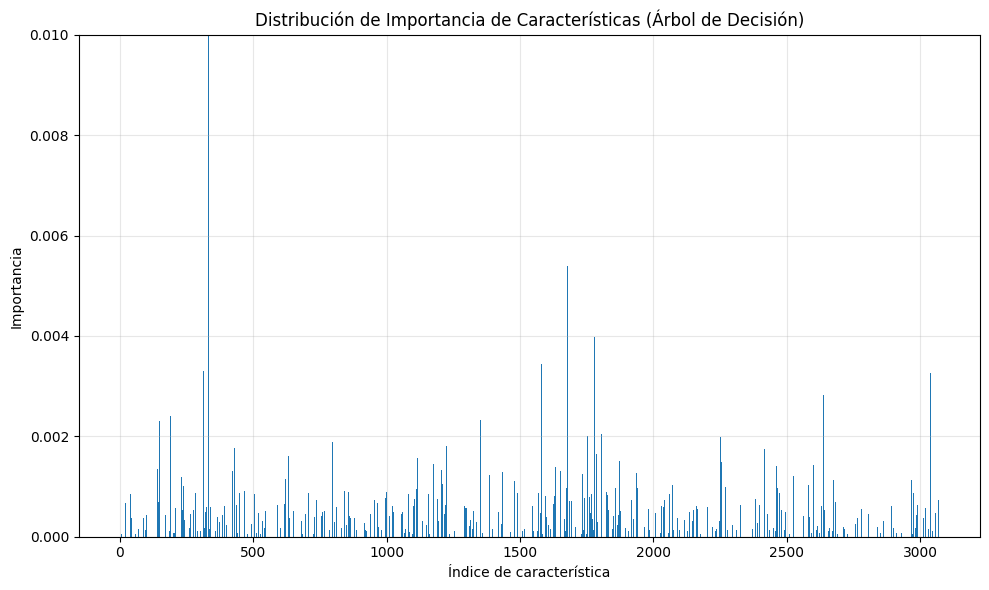


Características necesarias para 90% de importancia: 728
Porcentaje del total: 23.7%


In [19]:
analizar_importancia_caracteristicas(modelo)


ANÁLISIS DE COMPLEJIDAD DEL ÁRBOL
Número total de nodos: 3471
Profundidad del árbol: 25
Número de hojas: 1736
Muestras mínimas en una hoja: 1
Muestras máximas en una hoja: 227
Muestras promedio por hoja: 6.10


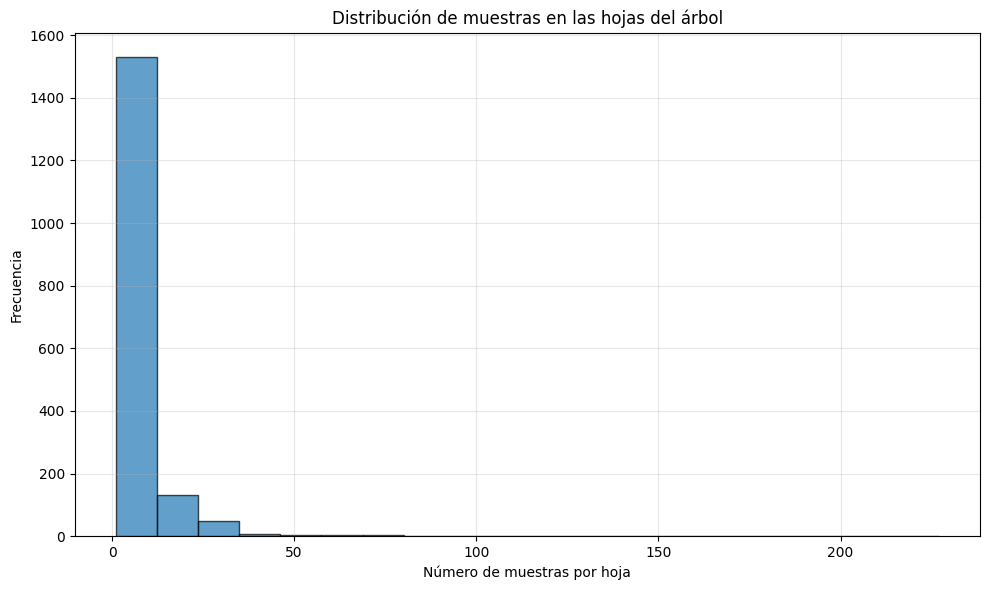

In [20]:
analizar_complejidad_arbol(modelo)


VISUALIZACIÓN DEL ÁRBOL DE DECISIÓN (PROFUNDIDAD LIMITADA)


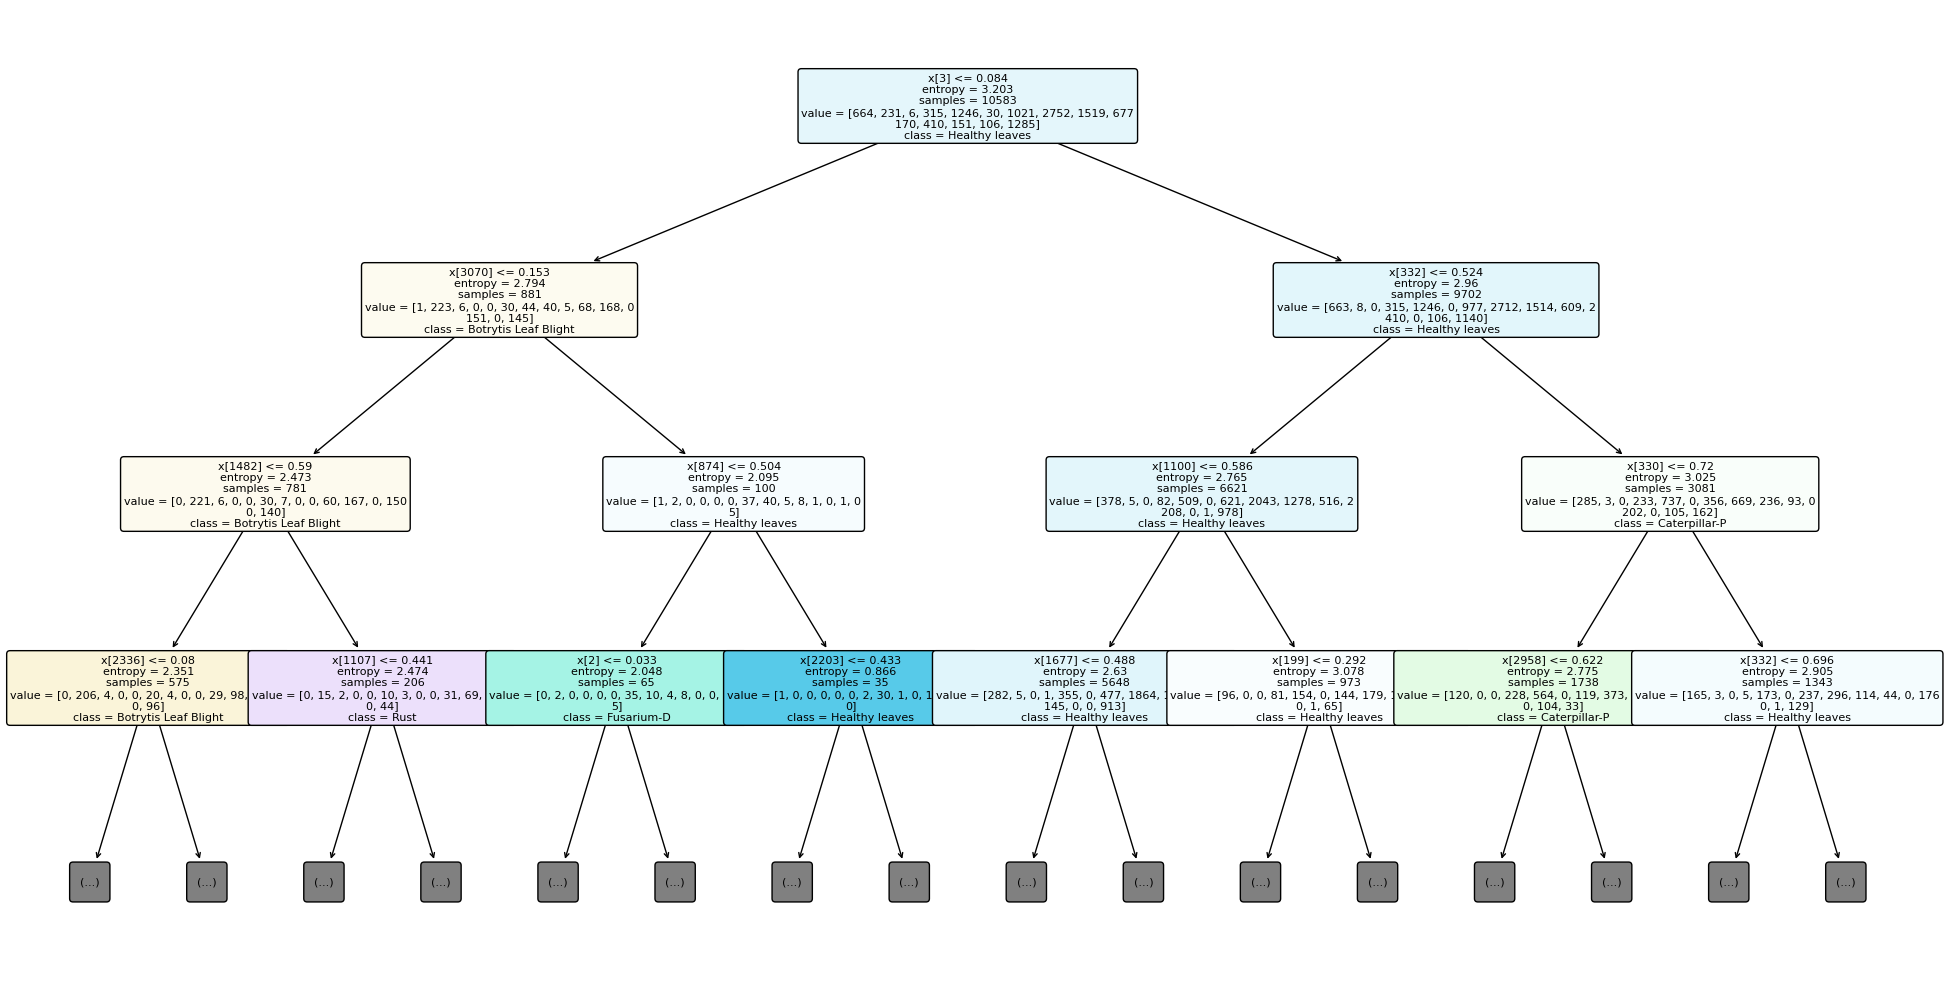

In [21]:
visualizar_arbol(modelo, label_encoder.classes_, max_depth_visual=3)

In [22]:
# 8. Guardar modelo y label encoder
joblib.dump(modelo,out_dir/ 'modelo_arbol_decision.pkl')
joblib.dump(label_encoder, out_dir/'label_encoder_dt.pkl')
print("\nModelo y LabelEncoder guardados.")


Modelo y LabelEncoder guardados.


In [23]:
# 9. Accuracy por clase
print("\n" + "=" * 60)
print("ACCURACY POR CLASE")
print("=" * 60)

accuracies_por_clase = []
for i, clase in enumerate(label_encoder.classes_):
    idx = np.where(y_test == i)[0]
    if len(idx) == 0:
        acc_clase = 0.0
    else:
        acc_clase = accuracy_score(y_test[idx], y_pred[idx])
        accuracies_por_clase.append(acc_clase)
        print(f"   {clase}: {acc_clase:.2%}")

accuracies_por_clase = np.array(accuracies_por_clase)
indices_ordenados = np.argsort(accuracies_por_clase)


ACCURACY POR CLASE
   Alternaria_D: 58.43%
   Botrytis Leaf Blight: 20.69%
   Bulb Rot: 0.00%
   Bulb_blight-D: 97.47%
   Caterpillar-P: 86.86%
   Downy mildew: 0.00%
   Fusarium-D: 69.80%
   Healthy leaves: 56.83%
   Iris yellow virus_augment: 31.84%
   Purple blotch: 45.29%
   Rust: 51.16%
   Virosis-D: 85.29%
   Xanthomonas Leaf Blight: 36.84%
   onion1: 96.15%
   stemphylium Leaf Blight: 35.83%


Predicciones con imagenes de prueba


PREDICCIÓN PARA UNA NUEVA IMAGEN

Clase predicha: Alternaria_D

Top 3 predicciones:
   1. Alternaria_D: 100.00%
   2. stemphylium Leaf Blight: 0.00%
   3. onion1: 0.00%


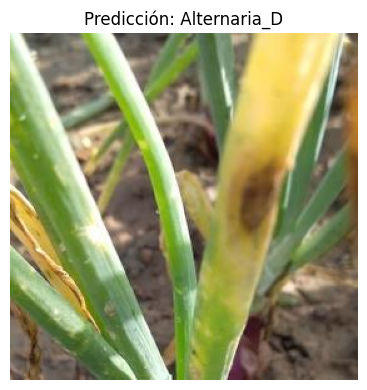

'Alternaria_D'

In [26]:
predecir_imagen("Imagenes_Prueba/Alternaria.jpg")


PREDICCIÓN PARA UNA NUEVA IMAGEN

Clase predicha: Rust

Top 3 predicciones:
   1. Rust: 100.00%
   2. stemphylium Leaf Blight: 0.00%
   3. onion1: 0.00%


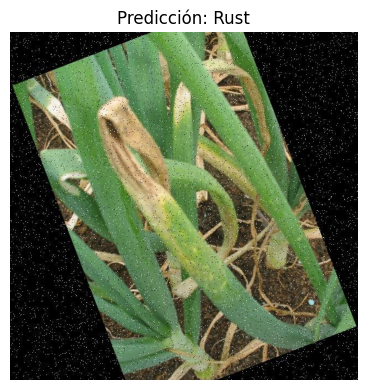

'Rust'

In [27]:
predecir_imagen("Imagenes_Prueba/Downy.jpg")


PREDICCIÓN PARA UNA NUEVA IMAGEN

Clase predicha: Iris yellow virus_augment

Top 3 predicciones:
   1. Iris yellow virus_augment: 100.00%
   2. stemphylium Leaf Blight: 0.00%
   3. onion1: 0.00%


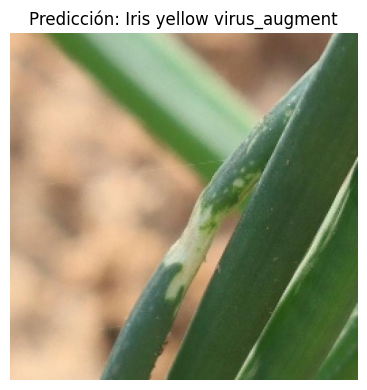

'Iris yellow virus_augment'

In [28]:
predecir_imagen("Imagenes_Prueba/Iris.jpg")


PREDICCIÓN PARA UNA NUEVA IMAGEN

Clase predicha: Purple blotch

Top 3 predicciones:
   1. Purple blotch: 100.00%
   2. stemphylium Leaf Blight: 0.00%
   3. onion1: 0.00%


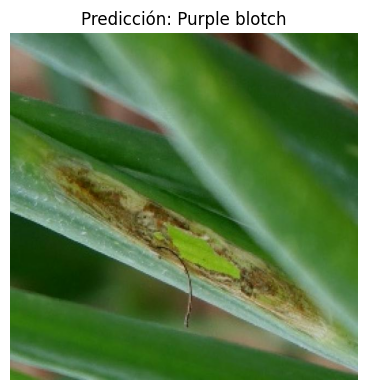

'Purple blotch'

In [29]:
predecir_imagen("Imagenes_Prueba/Purple.jpg")